# T distribution

这是一个相对简单的， API一致的分布

In [116]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import pymc3 as pm
import arviz as az

In [41]:
tdist = stats.t(loc = 0, scale= 1, df = 5)
normdist = stats.norm(loc = 0, scale = 1)

### 1. Compare t distribution with normal distribution

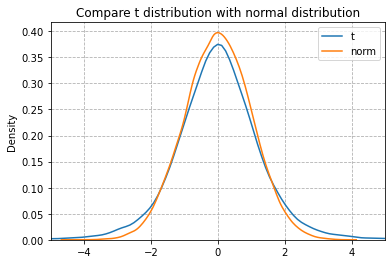

In [45]:
sns.kdeplot(tdist.rvs(30000), label = 't')
sns.kdeplot(normdist.rvs(30000), label = 'norm')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--')
plt.title('Compare t distribution with normal distribution', fontsize = 12)
plt.xlim(-5,5)
plt.show()

t distribution have heavy tails compared to normal         
In this case, t distribution have fixed mean           

我们试着让 $df = 1$

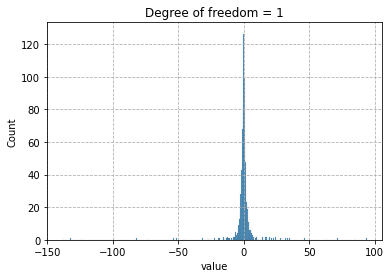

In [68]:
tdist = stats.t(loc = 0, scale= 1, df = 1)
sns.histplot(tdist.rvs(1000))
plt.grid(linestyle = '--')
plt.title('Degree of freedom = 1')
plt.xlabel('value')
plt.show()

In [81]:
tdist.rvs(1000).mean()

-35.68272881169281

发现算出来的均值远大于好几倍的标准差, 直方图上1个大值对这个均值又很大的影响， 所以。                 
$df<=1$时候，t分布是没有固定的均值的。           
只有再$df > 2$的时候，t分布的方差才是有定义的。    

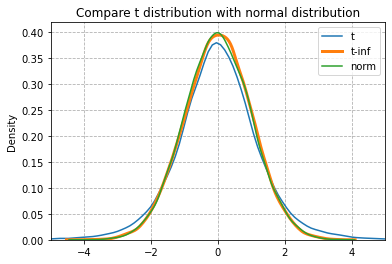

In [84]:
tdist = stats.t(loc = 0, scale= 1, df = 5)
sns.kdeplot(tdist.rvs(30000), label = 't')

tdist = stats.t(loc = 0, scale= 1, df = 5000)
sns.kdeplot(tdist.rvs(30000), label = 't-inf', linewidth = 3)


sns.kdeplot(normdist.rvs(30000), label = 'norm')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--')
plt.title('Compare t distribution with normal distribution', fontsize = 12)
plt.xlim(-5,5)
plt.show()

当$df$趋近与无穷的时候，t分布趋近于正态分布，你看这个曲线，多像

## Inside PYMC $\nu$

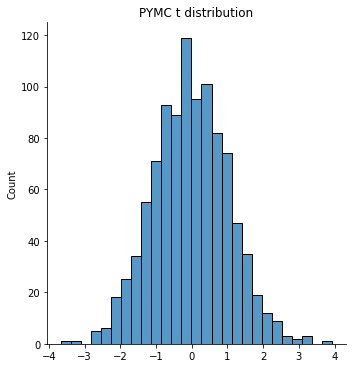

In [89]:
with pm.Model() as model:
    tdist = pm.StudentT('tdist', mu = 0, sigma = 1, nu = 30)
    
sns.displot(tdist.random(size = 1000))
plt.title('PYMC t distribution')
plt.show()

$\nu$ 越大把，说明观测的样本约足， 那最后得到的分布就更接近于正态分布

### 然后你要去先验一个t分布                       
1. 你大概看了一下原始数据的distribution
2. 你大概`.mean`了一下对mean有了一个先验 - normal先验
3. 你大概`.std`了一下，对std有了一个先验 - halfnormal先验
4. 你挂了，你不知道 $\nu$到底取多少合适
5. 你想用一个比较flat的先验，或者不那么flat的先验，你看了一下分布 问了自己一个问题： <font color = 'darkred'>这个分布到底像不像正太分布</font>
6. if 像， $nu$ 大一点儿， if 不像 $nu$ 小一点儿                 


So $nu$ 很大的时候，其实这个分布就收紧了一点儿，区别把，其实和$nu$小的时候不是特别大 


所以最后你决定用一个 0 - 好几十的分布做这个事儿 

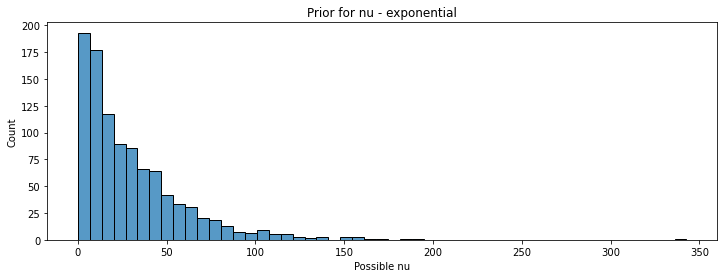

In [99]:
figsize(12,4)
with pm.Model() as model:
    nu = pm.Exponential('nu', 1/30)
    
sns.histplot(nu.random(size = 1000))
plt.title('Prior for nu - exponential')
plt.xlabel('Possible nu')
plt.show()

Scipy中的$df$ 和mc中的 $\nu$是一样的， 都是 degree of freedom

## Using t distribution

In [100]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45,
52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33,
57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99,
52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84,
53.16])

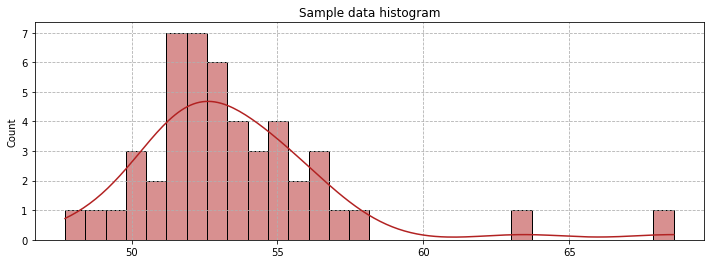

In [115]:
sns.histplot(data,kde = True, bins = 30, color = 'firebrick')
plt.title('Sample data histogram')
plt.grid(linestyle = '--')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A9852E4CD0>,
      dtype=object)

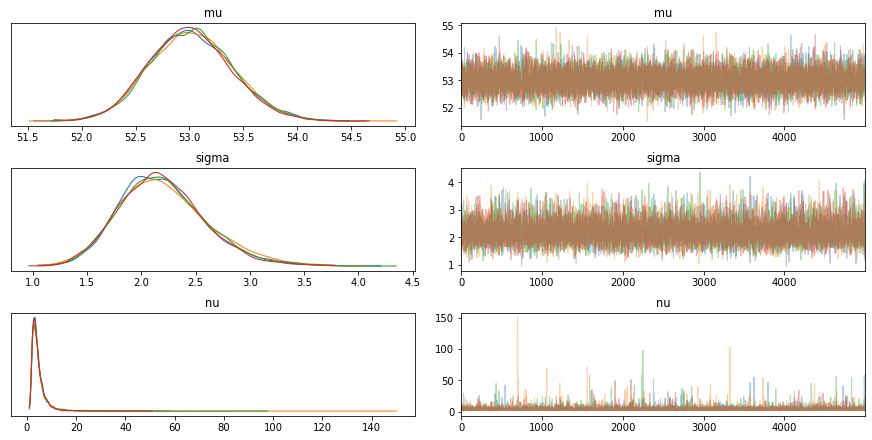

In [117]:
with pm.Model() as model:
    mu = pm.Normal('mu', 53, 20)
    sigma = pm.HalfNormal('sigma', 50)
    nu = pm.Exponential('nu',1/30)
    obs = pm.StudentT('obs', mu = mu, sigma = sigma, nu = nu, observed = data)
    step = pm.Metropolis()
    trace = pm.sample(5000, step = step, return_inferencedata=True)
    
az.plot_trace(trace)

In [118]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,53.016,0.386,52.302,53.745,0.003,0.002,12908.0,12882.0,13110.0,11723.0,1.0
sigma,2.198,0.407,1.470,2.978,0.004,0.003,8662.0,8639.0,8688.0,9458.0,1.0
nu,4.666,4.127,1.159,9.490,0.050,0.036,6697.0,6697.0,8849.0,7924.0,1.0


这里就忽略posterior predictive check吧